In [1]:
import warnings
"""
Some integration issues might lead to a warning but scipy should solve them
in itself. If you don't trust it turn this off and find stable values
"""
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.optimize as opt
from mpl_toolkits import mplot3d

from scipy.misc import derivative
from scipy import integrate

sns.set(rc={'figure.figsize': (12, 8)})

In [3]:
def plt_3d(X, Y, Z, title = '', labels = []):
    x_label, y_label, z_label = labels
    ax = plt.axes(projection='3d')
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_zlabel(z_label)
    ax.set_title(title)
    ax.plot_surface(X, Y, Z)
    return ax

def lineplot(x, y, labels):
    x_label, y_label = labels
    ax = sns.lineplot(x, y)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    
    return ax

### Bounded pareto distribution

First we implemented a bounded pareto density distribution as:

\begin{align}
    f(x) = \frac{\alpha \cdot L^{\alpha} \cdot x^{-(\alpha+1)}}{1 - \left(\frac{L}{H}\right)^{\alpha}}
\end{align}

note that in our case $H \xrightarrow{} \infty$ hence $f(x) = \alpha \cdot L^{\alpha} \cdot x^{-(\alpha+1)}$

In [4]:
from utils.distribution import BoundedParetoDensity

In [5]:
dens = BoundedParetoDensity(L=2)

expected_value = dens.E
print("Truncated density expected value: ", expected_value) 

Truncated density expected value:  2.4999999999999996


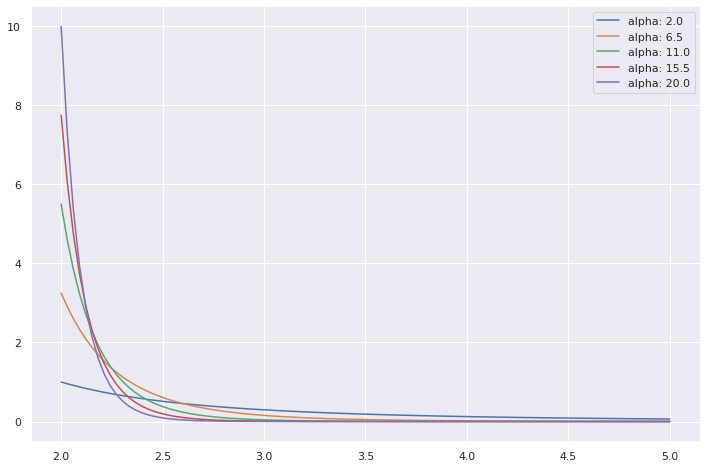

In [6]:
support = np.linspace(dens.L, 5, 100)
alphas = np.linspace(2, 20, 5)

df = pd.DataFrame(index=support)
for alpha in alphas:
    density = BoundedParetoDensity(alpha=alpha, L=dens.L)
    ys = [density.pdf(x) for x in support]
    df[f'alpha: {alpha}'] = ys

df.plot()

### Structural functions and constants

In [7]:
fixed_costs = 10
labour_supply = 2_000
cost_entry = 1

In [8]:
gamma = 0.7
delta = 0.2
r = 0.02

if r + delta >= 1:
    raise ValueError("The discount need to sum to less than 1")
    
if gamma >= 1:
    raise ValueError("Gamma should be smaller than 1, numerically make it even smaller")

In [9]:
def production(labour: float, prod_draw: float, gamma=gamma):
    return prod_draw*np.power(labour, gamma)

def marginal_costs(labour, wage):
    return labour*wage

def marginal_prod(labour, *args, **kwargs):
    """
    Computes the first order condition of production at a given labour.
    Forwards all other arguments to production
    """
    return derivative(lambda lab: production(lab, *args, **kwargs), labour)

def profit(
        labour, wage, prod_draw,
        fixed_costs=fixed_costs, **kwargs
        ):
    total_costs = marginal_costs(labour, wage) + fixed_costs
    
    return production(labour, prod_draw, **kwargs) - total_costs

### Part 1. Optimality on draw and wage

We are going to compute $l(w, s)$, $\pi(w, s)$, that will return the optimal labour and profit given a productivity draw $s$ and a wage $w$. Also we can define $y(w, s)$ as the analogous optimal output.

In [10]:
positive_bounds = ((0, None),)

@np.vectorize
def optimal_labour(wage, prod_draw, **kwargs):
    result = opt.minimize(
        lambda lab: -profit(lab, wage, prod_draw, **kwargs),
        0, bounds=positive_bounds)
    
    return result.x[0]

def optimal_production(wage, prod_draw, **kwargs):
    opt_labour = optimal_labour(wage, prod_draw, **kwargs)
    
    return production(opt_labour, prod_draw)

def pi(wage, prod_draw, **kwargs):
    opt_labour = optimal_labour(wage, prod_draw, **kwargs)
    
    return profit(opt_labour, wage, prod_draw, **kwargs)

In [11]:
W, S = np.meshgrid(np.linspace(1, 7, 30), np.linspace(1, 20, 30))

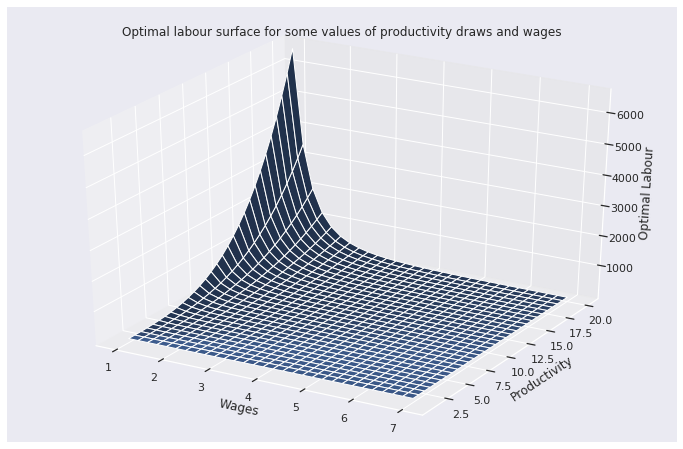

In [12]:
title = lambda what: f"Optimal {what} surface for some values of productivity draws and wages"
ax = plt_3d(W, S, optimal_labour(W, S),
            title("labour"), ["Wages", "Productivity", "Optimal Labour"])
plt.show()

### Part 2. Productivity threshold

Given a fixed cost $c_d$, a firm will hire labour unitil $s_d$, where 

\begin{align}
    s_d(w) = \{s_d:  \pi(w, s_d) = 0 \}
\end{align}

In [13]:
@np.vectorize
def threshold_draw(wage, x0=10, **kwargs):
    sd = opt.root(lambda s: pi(wage, s, **kwargs), x0)
    if not sd.success: raise RuntimeError(sd.message)

    return sd.x[0]

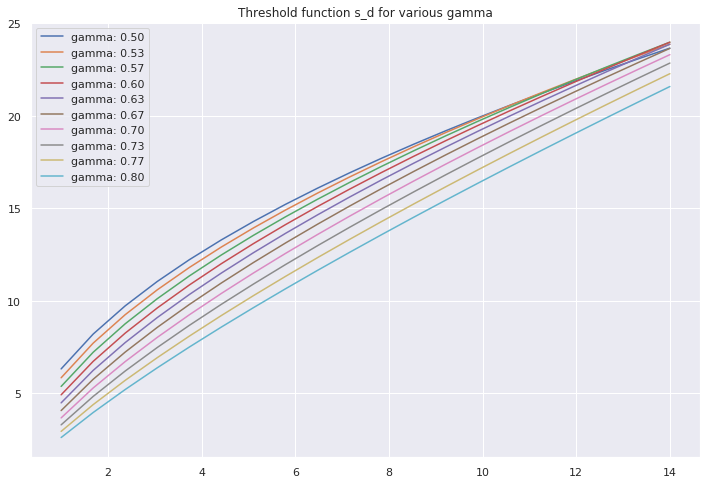

In [14]:
ws = np.linspace(1, 14, 20)
gammas = np.linspace(0.5, 0.8, 10)

df = pd.DataFrame(index=ws)
for g in gammas:
    thresholds = threshold_draw(ws, gamma=g)
    df[f"gamma: {g:.2f}"] = thresholds

df.plot(title="Threshold function s_d for various gamma")
plt.show()

### Part 3. 

We first define aggregate labour demand as 

\begin{align}
    L(w, N) = N \cdot \int^{\infty}_{s_d(w)} l(w, s) \cdot dG_{s_d(w)}(s)
\end{align}

where $G_{s_d}$ is the c.d.f. of the Bounded Pareto Distribution.

Starting from a given producitivity threshold $\underline{s}$, we can find the wage by

\begin{align}
    w = s_d^{-1}(\underline{s})
\end{align}

We can then define the aggregate profits $\Pi$ and output $Q$, similarly as $L$

\begin{align}
    \Pi(w, N) &= N \cdot \int^{\infty}_{s_d(w)} \pi(w, s) \cdot dG_{s_d(w)}(s) \\
    Q(w, N) &= N \cdot \int^{\infty}_{s_d(w)} y(w, s) \cdot dG_{s_d(w)}(s)
\end{align}

Note that
\begin{align*}
    E\left[ f(w, s) \right] := \int^{\infty}_{s_d(w)} f(w, s) \cdot dG_{s_d(w)}(s)
\end{align*}

In [15]:
def expected_value(fn, wage):
    sd = threshold_draw(wage)
    density = BoundedParetoDensity(L=sd)
    
    return density.integrate(lambda s: fn(wage, s))

In [16]:
s_under = 2.1
N = 1
wage = opt.root(lambda wage: threshold_draw(wage) - s_under, 1).x[0]
print(f"Wage associated with productivity draw s={s_under}: {wage}")

density = BoundedParetoDensity(L=s_under)

Wage associated with productivity draw s=2.1: 0.44951997899562707


In [17]:
L = N*expected_value(optimal_labour, wage)
O = N*expected_value(optimal_production, wage)
P = N*expected_value(pi, wage)

In [18]:
print(f"""
    With w={wage} and N={N}:
        aggregate labour demand L={L},
        aggregate output, Q={O},
        which yields total profits \Pi={P}
    """)


    With w=0.44951997899562707 and N=1:
        aggregate labour demand L=155.61737282227196,
        aggregate output, Q=99.94336631924864,
        which yields total profits \Pi=19.988435620794757
    


In order to find the $N$ that, given this wage clears the market we can simply use the exogenous labour supply

\begin{align}
    \overline{L} = L(w, N)
\end{align}

In [19]:
def find_clearing_N(wage):
    lower_s = threshold_draw(wage)
    density = BoundedParetoDensity(L=lower_s)
    expected_labour = expected_value(optimal_labour, wage)
    result = opt.root(
        lambda n: n*expected_labour - labour_supply, 1)
    
    if not result.success: raise RuntimeError(result.message)
        
    return result.x[0]

In [20]:
N = find_clearing_N(wage)

In [21]:
print(f"The labour market clears with a firm mass N={N}")

The labour market clears with a firm mass N=12.852035500458982


### Part 4 

Given the N found above, in order to find the mass of entrants in equilibrium $M$, we can use the stable flow condition,

\begin{align*}
    \delta \cdot N = \left(1 - G(s_d)\right)\cdot M
\end{align*}

where $G(.)$ is the Unbounded Pareto Distribution (i.e. the Pareto distribution bounded at $s_d = 1$)

In [22]:
unbounded_density = BoundedParetoDensity(L=1)
M = lambda N, sd: (delta*N)/(1-unbounded_density.cdf(sd))

In [23]:
print(
    f"Given a mass of incumbent firms N={N}, in equilibrium the mass of entrant is M={M(N, s_under)}")

Given a mass of incumbent firms N=12.852035500458982, in equilibrium the mass of entrant is M=104.97802207892057


### Part 5

The expected profit of an entrant firm is
\begin{align*}
      E\left[\pi(w, s)\right] = \int^{\infty}_{s_d(w)} \pi(w, s) \cdot dG(s)
\end{align*}

which in equilibrium has to be equal to the expected discounted cost of entry

\begin{align*}
    E\left[\pi(w, s)\right] = \frac{r+\delta}{r+1} \cdot c_e
\end{align*}

which implicitly defines $w$.

Note that $E\left[\pi(w, s) \right]$ is computed on $G(.)$, the unbounded c.d.f.

In [24]:
def unc_expectation(wage, fn):
    sd = threshold_draw(wage)
    density = BoundedParetoDensity(L=1)
    
    mass, _ = integrate.quad(lambda s: fn(wage, s)*density.pdf(s), sd, np.inf)
    
    return mass

In [25]:
def find_equilibrium_wage(cost_entry):
    present_value = cost_entry*(r+delta)/(r+1)
    result = opt.root(lambda w: unc_expectation(w, pi) - present_value, 2)
    
    if not result.success: raise RuntimeError(result.message)
        
    return result.x[0]

In [26]:
eq_wage = find_equilibrium_wage(cost_entry)

In [27]:
print(f"W={eq_wage}")

W=0.5680963615575558


### Part 6 - Equilibrium

We can now use this wage level, to find the full equilibrium $s_d, Q, M, N$, with the exogenous parameters $\gamma, c_d, c_e, \delta, r, \overline{L}$

In [28]:
print(f"""
    The equilibrium wage is approximately {eq_wage:.2f}
    The parameters are:
    gamma={gamma}, L={labour_supply}, cd={fixed_costs}, ce={cost_entry},
    delta={delta}, r={r}
    """)


    The equilibrium wage is approximately 0.57
    The parameters are:
    gamma=0.7, L=2000, cd=10, ce=1,
    delta=0.2, r=0.02
    


In [29]:
def equilibrium(wage):
    G = BoundedParetoDensity(L=1)
    
    s_d = threshold_draw(wage)
    N = find_clearing_N(wage)
    
    G_lower = unbounded_density.cdf(s_d)
    
    M = (delta*N)/(1-G_lower)
    Q = N*expected_value(optimal_production, wage)
    
    C = M * (1 - G_lower) * cost_entry + N*(1-delta)*fixed_costs
    Q_bar = Q / labour_supply
    
    return s_d, Q, M, N, C, Q_bar

In [30]:
s_d, Q, M, N, C, Q_bar = equilibrium(eq_wage)

In [31]:
print(f"Equilibrium values: s_d={s_d:.2f}, Q={Q:.2f}, M={M:.2f}, N={N:.2f}")

Equilibrium values: s_d=2.47, Q=1623.27, M=301.03, N=16.24


Then we can define the aggregate output per worker 
\begin{align*}
    \overline{Q} := \frac{Q(w)}{\overline{L}}
\end{align*}

and the aggregate costs of frictionless losses $C$, as

\begin{align*}
    C := M \cdot (1 - G(s_d)) \cdot c_e + N \cdot (1-\delta) \cdot c_f
\end{align*}

and they respectively are

In [32]:
print(f"Q_bar={Q_bar:.2f}, C={C:.2f}")

Q_bar=0.81, C=133.18
